# 4.1 Imports

In [29]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter

from numpy import mean, std

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV

from imblearn.over_sampling import ADASYN
from imblearn.pipeline import make_pipeline

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# load train data
train = pd.read_csv('data/train_prep_1.csv')

In [4]:
# load test data
test = pd.read_csv('data/test_prep_1.csv')

In [5]:
train.shape

(32462, 12)

In [6]:
test.shape

(16232, 12)

In [7]:
X_train = train.drop(columns=['target'])
X_train.shape

(32462, 11)

In [8]:
X_test = test.drop(columns=['target'])
X_test.shape

(16232, 11)

In [9]:
y_train = train['target']
y_train.shape

(32462,)

In [10]:
y_test = test['target']
y_test.shape

(16232,)

# 4.2 Logistic Regression

In [11]:
# numerical features
num_features = ['age','education','hours_per_week']

# numerical transformer
num_transformer = StandardScaler()

In [12]:
# categorical features
cat_features = ['workclass','marital_status','occupation','relationship',
               'race','sex','capital_change','native_country']

# categorical transformer
cat_transformer = OneHotEncoder(handle_unknown='ignore')

In [13]:
# preprocessing

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

In [14]:
# whole model pipeline

logistic_regression = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier',LogisticRegression(random_state=20210510, n_jobs=-1))
])

In [15]:
# model fitting
logistic_regression.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'education',
                                                   'hours_per_week']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['workclass',
                                                   'marital_status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'capital_change',
                                                   'native_country'])])),
                ('classifier',
                 LogisticRegression(n_jobs=-1, random_state=20210510))])

In [16]:
# model evaluations can be put in the end
# for different models comparison
# create functions for repeatations

In [42]:
# model evaluation

def print_score(model):
    print('model score: %.3f' % model.score(X_test,y_test))
    print('\n')

In [35]:
# model evaluation
print_score(logistic_regression)

model score: 0.843


In [18]:
# k-fold cross validation

# cross validation
cv = KFold(n_splits=10, random_state=20210517, shuffle=True)

# evaluate model
scores = cross_val_score(logistic_regression, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1)

print('K-fold cross validation accracy score: %.3f (%.3f)' % (mean(scores), std(scores)))

K-fold cross validation accracy score: 0.843 (0.010)


In [37]:
# classification reports

def print_classfication_reports(model):
    y_test_pred = model.predict(X_test)

    print('Classification report on test data:')
    print(classification_report(y_test, y_test_pred))

    y_train_pred = model.predict(X_train)

    print('Classification report on train data:')
    print(classification_report(y_train, y_train_pred))

In [38]:
# classification reports
print_classfication_reports(logistic_regression)

Classification report on test data:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90     12397
           1       0.71      0.57      0.63      3835

    accuracy                           0.84     16232
   macro avg       0.79      0.75      0.77     16232
weighted avg       0.84      0.84      0.84     16232

Classification report on train data:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90     24635
           1       0.71      0.58      0.64      7827

    accuracy                           0.84     32462
   macro avg       0.79      0.75      0.77     32462
weighted avg       0.84      0.84      0.84     32462



Logistic regression: ROC AUD = 0.894


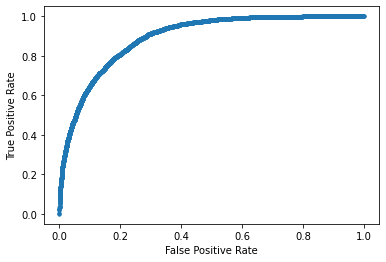

In [20]:
# area under curve (AUC) of receiver operating charisteristic (ROC) curve

# predict probabilities
model_probs = logistic_regression.predict_proba(X_test)

# keep probabilities for the positive outcome only
model_probs = model_probs[:, 1]

# calculate scores
model_auc = roc_auc_score(y_test, model_probs)

# summarize scores
print('Logistic regression: ROC AUD = %.3f' % (model_auc))

# calculate roc curves
# fpr, tpr: false positive rate, true positive rate
fpr, tpr, _ = roc_curve(y_test, model_probs)

# plot roc curve
plt.plot(fpr, tpr, marker='.', label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.legend()
plt.show()

In [21]:
# grid search

param_grid = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [0.1, 1.0, 10, 100]
}

In [22]:
grid_search = GridSearchCV(logistic_regression, param_grid, cv=10)
grid_search

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'education',
                                                                          'hours_per_week']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['workclass',
                                                                          'marital_status',
                                                                          'occupation',
                               

In [23]:
%%time

grid_search.fit(X_train, y_train)

print("Best params:")
print(grid_search.best_params_)

Best params:
{'classifier__C': 1.0, 'classifier__penalty': 'l2'}
Wall time: 54.8 s


# 4.3 Logistic Regression with SMOTE

In [24]:
# preprocessing stay the same
# only edit the whole model pipeline

In [25]:
# oversampler
adasyn = ADASYN(random_state=20210517,n_jobs=-1)

In [26]:
# as 'pipeline' in sklearn library does not support 'adasyn'
# 'adasyn' function has no .fit_transform
# have to use 'make_pipeline' in imblearn library

logistic_adasyn = make_pipeline(preprocessor, adasyn ,LogisticRegression(random_state=20210510, n_jobs=-1))

In [27]:
# model fitting
logistic_adasyn.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'education',
                                                   'hours_per_week']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['workclass',
                                                   'marital_status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'capital_change',
                                                   'native_country'])])),
                ('adasyn', ADASYN(n_jobs=-1, random_state=20210517)),
                ('logisticregression',
                 LogisticRegression(n_jobs=-1, random_state=202105

In [28]:
# model evaluation
print('model score: %.3f' % logistic_adasyn.score(X_test,y_test))

model score: 0.771


# 4.4 Linear Support Vector Classification (SVC)

In [30]:
# preprocessing stay the same
# only edit the whole model pipeline

In [31]:
# whole model pipeline

linear_svc = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier',LinearSVC(random_state=20210518))
])

In [32]:
# model fitting
linear_svc.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'education',
                                                   'hours_per_week']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['workclass',
                                                   'marital_status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'capital_change',
                                                   'native_country'])])),
                ('classifier', LinearSVC(random_state=20210518))])

In [41]:
# model evaluation
print_score(linear_svc)

# classification reports
print_classfication_reports(linear_svc)

model score: 0.844
Classification report on test data:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90     12397
           1       0.71      0.57      0.63      3835

    accuracy                           0.84     16232
   macro avg       0.79      0.75      0.77     16232
weighted avg       0.84      0.84      0.84     16232

Classification report on train data:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90     24635
           1       0.72      0.57      0.64      7827

    accuracy                           0.84     32462
   macro avg       0.80      0.75      0.77     32462
weighted avg       0.84      0.84      0.84     32462



In [ ]:
#END